In [24]:
%load_ext autoreload
%autoreload 2 
# !apt-get install -y xvfb
import time
import torch
import scipy
import scipy.sparse
from collections import Counter
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
# https://www.youtube.com/watch?v=QLIkOtKS4os --> creating custom dataset in pytorch geometric
from torch.utils.data import Dataset, random_split
import torch_geometric
from torch_geometric.data import Data, InMemoryDataset
import torch_geometric
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GlobalAttention
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.utils import to_networkx, from_networkx
from sklearn.model_selection import StratifiedKFold
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import pickle
import seaborn as sn
import random
import os

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

from graph_utils import set_device_and_seed, set_seed, show, visualize_graph, visualize_embedding, _count_parameters, visualise_airway_tree_matplotlib
from graph_datasets import CustomDataset
from graph_models import CustomGlobalAttention, GAT
from graph_training import train_model, test_model, _vis_graph_example, train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data


In [5]:
orig_df = pd.read_csv(os.path.abspath("/home/sneha/e5_cleaned_normalised_0207.csv"))
orig_df.describe()

,idno,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,dircosy,dircosz,weibel_generation,x,y,z,parent_loc_x,parent_loc_y,parent_loc_z,endbpid_nn_in_lobe,dist_nn_in_lobe,num_desc,max_path_length,centerlinelength_norm,avginnerarea_norm,dist_nn_in_lobe_norm,max_path_length_norm,angle_norm,weibel_generation_norm,num_desc_norm,lobe_norm,sublobe_norm,x_norm,y_norm,z_norm,parent_loc_x_norm,parent_loc_y_norm,parent_loc_z_norm,dircosx_norm,dircosy_norm,dircosz_norm
count,8.841330e+05,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.00000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,8.841330e+05,8.841330e+05,8.841330e+05,8.841330e+05,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000,884133.000000
mean,5.383731e+06,10.962737,12.322837,2.780542,8.795393,180.396147,130.48361,142.894554,-0.009455,0.038263,0.103872,6.936955,0.007336,28.940803,142.867836,0.244255,28.800929,140.969207,181.365308,6.791313,6.936955,23.434302,3.554741e-17,-1.201015e-15,8.765452e-16,2.297306e-16,0.793859,0.693696,0.009056,0.556108,0.462915,0.489945,0.519475,0.459284,0.477732,0.527059,0.471059,0.495273,0.519132,0.551936
std,1.770937e+06,9.992955,28.396421,1.493876,5.567604,120.961988,104.05128,25.471729,0.549856,0.546360,0.621939,1.942044,55.698296,31.035400,46.983350,51.533963,26.989735,42.838421,119.290994,5.968240,25.414778,25.281900,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.141510,0.194204,0.033179,0.298775,0.293032,0.191099,0.115638,0.149080,0.196813,0.107416,0.143148,0.274928,0.273180,0.310969
min,3.010007e+06,0.466797,-1.000000,0.000000,0.000000,1.000000,-1.00000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-142.793967,-110.478675,-1.877806,-124.846262,-103.630217,0.000000,1.000000,0.000000,0.000000,0.466797,-1.050334e+00,-4.691734e-01,-1.137909e+00,-9.084570e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.013247e+06,4.452000,4.294160,2.000000,4.000000,84.000000,47.00000,132.852000,-0.453427,-0.408248,-0.444444,6.000000,-48.685005,9.158236,104.792507,-45.244404,11.843952,106.992379,86.000000,2.166590,0.000000,6.016110,-6.515330e-01,-2.827357e-01,-7.748894e-01,-6.889594e-01,0.738067,0.600000,0.000000,0.400000,0.210526,0.322884,0.445766,0.338470,0.304007,0.459572,0.357523,0.273286,0.295876,0.277778
50%,5.018404e+06,9.051960,6.539240,3.000000,9.000000,164.000000,106.00000,149.771000,0.000000,0.028006,0.172917,7.000000,-25.808446,30.840235,143.629254,-25.426142,30.082224,141.673439,165.000000,5.539360,0.000000,16.710900,-1.912125e-01,-2.036736e-01,-2.097693e-01,-2.659375e-01,0.832061,0.700000,0.000000,0.600000,0.473684,0.401372,0.526553,0.461700,0.379695,0.532158,0.473412,0.500000,0.514003,0.586458
75%,7.015895e+06,14.460800,10.895900,4.000000,13.000000,257.000000,193.00000,160.337000,0.446663,0.481543,0.675725,8.000000,53.433956,50.449104,178.211029,50.452742,46.993111,172.692344,258.000000,9.275430,4.000000,32.695200,3.500531e-01,-5.025063e-02,4.162230e-01,3.663057e-01,0.890761,0.800000,0.005222,0.800000,0.684211,0.673250,0.599615,0.571430,0.669483,0.599461,0.577064,0.723332,0.740772,0.837862
max,8.024995e+06,149.707000,3176.890000,5.000000,19.000000,988.000000,922.00000,180.000000,1.000000,1.000000,1.000000,10.000000,148.669752,157.906512,313.277056,136.995991,147.634187,299.260114,987.000000,124.412044,766.000000,330.302540,1.388422e+01,1.114425e+02,1.970779e+01,1.213787e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# label_df = pd.read_csv(os.path.abspath("/home/sneha/MESA_Exam5_airway_variants.csv"))

### Make TOY DATASET

- for half the ids, remove lobe 2
- for the other half, remove lobe 3
- dont use lobes / sublobe info for training

In [8]:
list_of_ids = list(orig_df.idno.unique())
split = int(len(list_of_ids)/2)
random.shuffle(list_of_ids)
remove_lobe_from = list_of_ids[:split]

print(len(remove_lobe_from))

label_df = pd.DataFrame({'idno': list_of_ids, 'binaryLL_1': np.zeros_like(orig_df.idno.unique())})
label_df.loc[label_df.idno.isin(remove_lobe_from), 'binaryLL_1'] = 1



1455


1455

In [13]:
anomaly_half = orig_df.loc[(orig_df.idno.isin(remove_lobe_from)) & (orig_df.lobe != 2)]
normal_half = orig_df.loc[~(orig_df.idno.isin(remove_lobe_from))]
pilot_df = pd.concat([anomaly_half, normal_half], axis=0)
# pilot_df['anomaly_label_lobe'] = pilot_df.idno.apply(lambda x: 1 if x in remove_lobe_from else 0)

pilot_df = pilot_df.merge(label_df, on='idno', how='left')
pilot_df

,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,dircosy,dircosz,weibel_generation,QC,x,y,z,parent_loc_x,parent_loc_y,parent_loc_z,endbpid_nn_in_lobe,dist_nn_in_lobe,num_desc,max_path_length,centerlinelength_norm,avginnerarea_norm,dist_nn_in_lobe_norm,max_path_length_norm,angle_norm,weibel_generation_norm,num_desc_norm,lobe_norm,sublobe_norm,x_norm,y_norm,z_norm,parent_loc_x_norm,parent_loc_y_norm,parent_loc_z_norm,dircosx_norm,dircosy_norm,dircosz_norm,binaryLL_1
0,3010007,Trachea,104.96200,351.51300,0.0,0.0,1.0,-1.0,0.0000,-0.024446,0.229788,0.972934,0,True,-2.565859,24.119008,102.121099,0.000000,0.000000,0.000000,2.0,25.444202,350,267.26709,9.406558,11.944828,3.125360,9.644565,0.000000,0.0,0.456919,0.0,0.000000,0.481117,0.501509,0.329993,0.476800,0.412435,0.000000,0.487777,0.614894,0.986467,1
1,3010007,LMB,51.01420,148.68100,0.0,0.0,3.0,1.0,140.0360,0.608512,0.045926,0.792214,1,True,28.476894,26.461861,142.535262,-2.565859,24.119008,102.121099,1.0,51.014175,178,162.30509,4.007972,4.801952,7.409704,5.492897,0.777978,0.1,0.232376,0.0,0.000000,0.587623,0.510239,0.458229,0.467000,0.508425,0.341245,0.804256,0.522963,0.896107,1
2,3010007,RMB,25.44420,215.56900,0.0,0.0,2.0,1.0,134.8050,-0.694225,-0.047878,0.718164,1,True,-20.229859,22.900801,120.394207,-2.565859,24.119008,102.121099,1.0,25.444202,170,162.95772,1.449168,7.157461,3.125360,5.518711,0.748917,0.1,0.221932,0.0,0.000000,0.420512,0.496970,0.387974,0.467000,0.508425,0.341245,0.152888,0.476061,0.859082,1
3,3010007,BronInt,29.83190,111.98300,0.0,0.0,4.0,2.0,160.3120,-0.417837,0.018167,0.908341,2,True,-32.694730,23.442751,147.491745,-20.229859,22.900801,120.394207,8.0,8.901796,108,137.51352,1.888248,3.509605,0.353619,4.512291,0.890622,0.2,0.140992,0.0,0.000000,0.377746,0.498990,0.473956,0.399540,0.503577,0.402306,0.291081,0.509083,0.954171,1
4,3010007,RUL,16.64940,75.69660,3.0,0.0,5.0,2.0,98.5825,-0.813123,-0.038720,-0.580802,2,True,-33.767869,22.256133,110.724202,-20.229859,22.900801,120.394207,11.0,3.605171,60,72.93537,0.569068,2.231753,-0.533850,1.957966,0.547681,0.2,0.078329,0.6,0.000000,0.374064,0.494568,0.357291,0.399540,0.503577,0.402306,0.093438,0.480640,0.209599,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781860,8024880,-,1.75781,5.54813,2.0,7.0,154.0,142.0,125.2640,0.000000,1.000000,0.000000,10,False,65.636908,29.590875,169.663796,65.636908,27.833065,169.663796,142.0,1.757810,0,1.75781,-0.921142,-0.238576,-0.843382,-0.857392,0.695911,1.0,0.000000,0.4,0.368421,0.715118,0.521897,0.544309,0.727473,0.523207,0.566944,0.500000,1.000000,0.500000,0
781861,8024880,-,1.00000,-1.00000,2.0,7.0,157.0,143.0,106.6990,0.000000,0.000000,1.000000,10,False,69.153983,23.239590,171.284247,69.153983,23.239590,170.284247,143.0,1.000000,0,1.00000,-0.996977,-0.469173,-0.970356,-0.887367,0.592772,1.0,0.000000,0.4,0.368421,0.727185,0.498233,0.549451,0.740905,0.504926,0.569018,0.500000,0.500000,1.000000,0
781862,8024880,-,3.09565,5.25481,2.0,7.0,156.0,143.0,144.9020,0.928477,0.000000,0.371391,10,False,72.028223,23.239590,171.433944,69.153983,23.239590,170.284247,157.0,2.878135,0,3.09565,-0.787264,-0.248906,-0.655667,-0.804475,0.805011,1.0,0.000000,0.4,0.368421,0.737046,0.498233,0.549926,0.740905,0.504926,0.569018,0.964238,0.500000,0.685696,0
781863,8024880,-,18.42000,3.83302,5.0,19.0,158.0,147.0,160.7140,-0.332116,0.724616,0.603847,10,False,-47.287741,56.402206,182.554617,-41.170164,43.054780,171.431756,159.0,9.879564,0,18.42000,0.746252,-0.298975,0.517448,-0.198336,0.892856,1.0,0.000000,1.0,1.000000,0.327678,0.621796,0.585212,0.319567,0.583787,0.572852,0.333942,0.862308,0.801924,0


### Train test split mask

In [19]:
train_ids, test_ids = train_test_split(label_df, n_splits_test = 5, seed=0)

pilot_df_train = pilot_df.loc[pilot_df.idno.isin(train_ids)]
pilot_df_test = pilot_df.loc[pilot_df.idno.isin(test_ids)]
binary_label_df_train = label_df.loc[label_df.idno.isin(train_ids)]
binary_label_df_test = label_df.loc[label_df.idno.isin(test_ids)]
print("Overall Label frequency distribution", [(x, binary_label_df_test["binaryLL_1"].tolist().count(x)) for x in set(binary_label_df_test["binaryLL_1"].tolist())])


# SAVE PILOT DF for training
pilot_df_train.to_csv('/home/sneha/toy_lobe_cleaned_normalised_w_labels_train.csv')
binary_label_df_train.to_csv('/home/sneha/toy_lobe_binary_labels_train.csv')
pilot_df_test.to_csv('/home/sneha/toy_lobe_cleaned_normalised_w_labels_test.csv')
binary_label_df_test.to_csv('/home/sneha/toy_lobe_binary_labels_test.csv')

Overall Label frequency distribution [(0, 1456), (1, 1455)]
Getting train test split stratified on the 2911 labels
Overall Label frequency distribution [(0, 292), (1, 291)]


## Visualise normal vs anomalous example

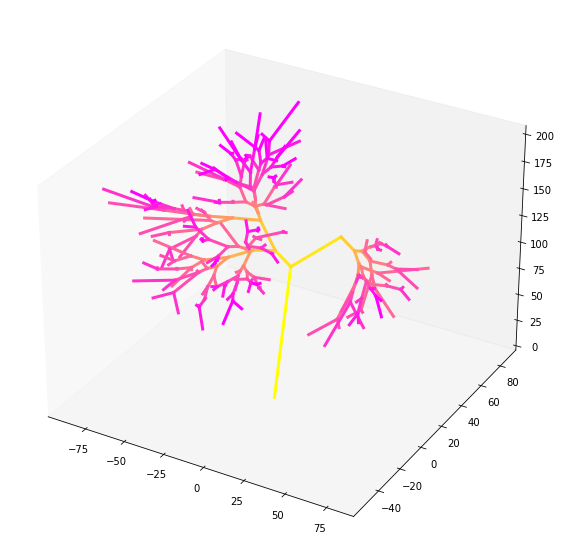

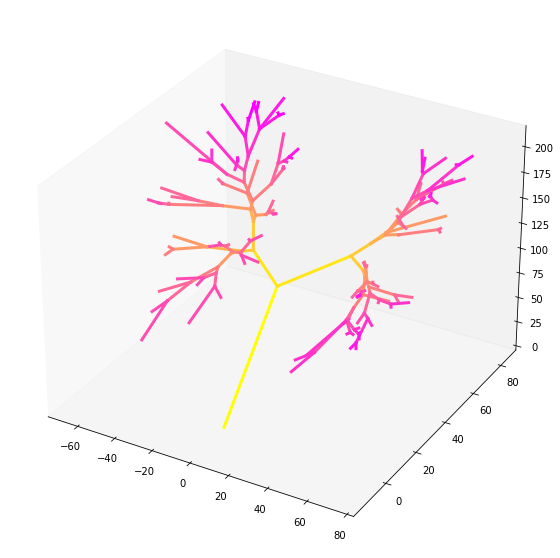

In [26]:
index_anomaly = random.choice(remove_lobe_from)
index_not_anomaly = random.choice([i for i in pilot_df.idno.unique() if i not in remove_lobe_from])
visualise_airway_tree_matplotlib(pilot_df, index_anomaly)
visualise_airway_tree_matplotlib(pilot_df, index_not_anomaly)


# Training Pipeline

In [29]:
run_id = 3
try:
    os.makedirs(f'/home/sneha/airway_exploration/graph_networks/run_{run_id}/')
except:
    pass

verbose= True
device = set_device_and_seed(GPU=True, gpu_name='cuda:1')
print("Device", device)

batch_size = 256
num_epochs = 200
count_epochs = 0
test_every = 1
weighted_loss = False
model_agg = 'attn'
dropout = 0.2
hidden_dim1 = 8
hidden_dim2 = 8
lr=0.005
weight_decay=5e-4

# 'lobe_norm','sublobe_norm' removed from features for toy example, added edge features to node ones too just in case
node_features = ['x_norm', 'y_norm', 'z_norm', 'dircosx_norm',
               'dircosy_norm', 'dircosz_norm','angle_norm', 'weibel_generation_norm','dist_nn_in_lobe_norm', 'num_desc_norm','max_path_length_norm','centerlinelength_norm','avginnerarea_norm']
edge_feature_names = ['centerlinelength_norm','avginnerarea_norm']

args = {'node_feature_names': node_features, 'edge_feature_names':edge_feature_names}
# DATASETS
my_data_train  = CustomDataset('data_train_toy/',
                               '/home/sneha/toy_lobe_cleaned_normalised_w_labels_train.csv',
                               "/home/sneha/toy_lobe_binary_labels_train.csv",
                               args = args
                              )

my_data_test  = CustomDataset('data_test_toy/', 
                              '/home/sneha/toy_lobe_cleaned_normalised_w_labels_test.csv',
                              "/home/sneha/toy_lobe_binary_labels_test.csv",
                              args = args
                             )



train_loader = DataLoader(my_data_train, batch_size=batch_size, shuffle=True)
test_loader =  DataLoader(my_data_test, batch_size=batch_size, shuffle=False)



if weighted_loss:

    class_prop = my_data_train.class_proportions
    class_weight_tensor = torch.tensor([1/class_prop[0], 1/class_prop[1]], dtype=float)
    mag = class_weight_tensor.sum()
    class_weight_tensor = class_weight_tensor/mag
    print("class weights for weighted loss", class_weight_tensor)

else:
    class_weight_tensor = None


model = GAT(agg=model_agg,dropout=dropout, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
model.train()
test_accuracy = []
test_f1 = []
test_cm = []
test_epoch = []
train_accuracy = []
train_loss = []
while count_epochs <= (num_epochs-test_every):
    print(f"Training epochs: {count_epochs} to {count_epochs+test_every} ")
    plotting_dict_train = train_model(model, optimizer ,train_loader, device,num_epochs=test_every, count_epochs=count_epochs, verbose=verbose, class_weight =class_weight_tensor)
    count_epochs += test_every
    train_accuracy.extend(plotting_dict_train['accuracy'])
    train_loss.extend(plotting_dict_train['loss'])
    
    
    
    # test model
    cm, f1, accuracy =  test_model(model, test_loader, device, count_epochs, threshold=0.5)
    test_epoch.append(count_epochs)
    test_cm.append(cm)
    test_f1.append(f1)
    test_accuracy.append(accuracy)
    
    print("Visualise training progress")
    f, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(np.arange(0,len(train_accuracy)), train_accuracy, label='train_accuracy')
    ax2.plot(np.arange(0,len(train_loss)), train_loss, label='train_loss')
    ax1.set_xlabel('epoch')
    ax2.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax2.set_ylabel('loss')
    plt.title('Training')
    plt.savefig(f'/home/sneha/airway_exploration/graph_networks/run_{run_id}/training_epoch_{count_epochs}')
    plt.show()
    
    f, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(test_epoch, test_accuracy, label='test_accuracy')
    ax2.plot(test_epoch, test_f1, label='test_f1')
    ax1.set_xlabel('epoch')
    ax2.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax2.set_ylabel('f1')
    plt.title('Testing')
    plt.savefig(f'/home/sneha/airway_exploration/graph_networks/run_{run_id}/test_epoch_{count_epochs}')
    plt.show()
    
#   vis_ids are one anomalous and one normal all in train data not test
    for i in range(0,2):
        
        id_test = label_df.iloc[np.argmax((label_df.binaryLL_1==i))].idno
        index_test = [index for index, (idno, relabel) in train_loader.dataset.node_map.items() if idno==id_test][0]
        _vis_graph_example(train_loader,model, index_test, pilot_df, visualise_g = False, save_path = f'/home/sneha/airway_exploration/graph_networks/run_{run_id}/training_vis_epoch_{count_epochs}_{i}')

Using cuda:1
Setting torch, cuda, numpy and random seeds to 0
Device cuda:1


TypeError: super(type, obj): obj must be an instance or subtype of type